# Project 1
## Sky Cen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Store training and test data

In [2]:
training_file = "textA.txt"
test_file = "textB.txt"

def store_data(file_name):
    f = open(file_name, "r")
    text = f.read()
    data = [26 if ord(c) == 32 else ord(c) - 97 for c in list(text)]
    return data

train = np.array(store_data(training_file)[:-1])
test = np.array(store_data(test_file)[:-1])


Initialize transition and emission probability matrices

In [ ]:
def init_hmm(num_states):
    if num_states == 2:
        A = np.array([[0.49, 0.51], 
                    [0.51, 0.49]])
        B = np.zeros((27, 2, 2))
        B[0:13] = np.array([[0.0370, 0.0371],
                        [0.0370, 0.0371]])
        B[13:26] = np.array([[0.0371, 0.0370],
                            [0.0371, 0.0370]])
        B[26] = np.array([[0.0367, 0.0367],
                        [0.0367, 0.0367]])
    return A, B

Define forward and backward algorithm

In [4]:
def forward(A, B, alpha_0, data):
    alphas = np.zeros((len(data) + 1, len(alpha_0)))
    alphas[0] = alpha_0

    qs = np.zeros((len(data) + 1))
    qs[0] = 1

    for i in range(len(data)):
        alphas[i + 1] = (np.multiply(A, B[data[i]]).T) @ alphas[i]
        qs[i + 1] = np.sum(alphas[i + 1])
        alphas[i + 1] = alphas[i + 1] / qs[i + 1]

    return alphas, qs


def backward(A, B, data, qs):
    beta_n = np.ones(A.shape[0])
    betas = np.zeros((len(data) + 1, len(beta_n)))
    betas[-1] = beta_n

    for i in range(len(data) - 1, -1, -1):
        betas[i] = ((np.multiply(A, B[data[i]])) @ betas[i + 1]) / qs[i]

    return betas


def unnormalize_alphas(alphas, qs):
    assert alphas.shape[0] == len(qs)

    unnormalized_probs = np.zeros_like(alphas)

    prod_qs = 1
    for i in range(len(qs)):
        prod_qs *= qs[i]
        unnormalized_probs[i] = alphas[i] * prod_qs
    
    return unnormalized_probs


def unnormalize_betas(betas, qs):
    assert betas.shape[0] == len(qs)

    unnormalized_probs = np.zeros_like(betas)
    unnormalized_probs[-1] = betas[-1]

    prod_qs = 1

    for i in range(len(qs) - 2, -1, -1):
        prod_qs *= qs[i]
        unnormalized_probs[i] = betas[i] * prod_qs
    
    return unnormalized_probs

# # test
# A = np.array([[1/2, 1/6, 1/6], [0, 0, 1/3], [3/4, 1/4, 0]])
# B = np.array([[[1, 1/2, 1], [0, 0, 1/3], [0, 0, 0]], [[0, 1/2, 0], [0, 0, 2/3], [1, 1, 0]]])
# alphas, qs = forward(A, B, np.array([1, 0, 0]), [0, 1, 1, 0])
# betas = backward(A, B, [0, 1, 1, 0], qs)

# print(alphas)
# print(betas)

# u_alphas = unnormalize_alphas(alphas, qs)
# u_betas = unnormalize_betas(betas, qs)
# marginal = np.sum(u_alphas[-1])

# print(marginal)

# assert np.isclose(np.prod(qs), marginal)
# assert np.isclose(u_betas[0][0], marginal)

# for i in range(len(alphas)):
#     assert np.isclose(np.sum(u_alphas[i] * u_betas[i]), marginal)

Define Baum-Welch algorithm

In [ ]:
def baum_welch(A, B, train_data, test_data, letters, iterations):
    
    train_log_probs = []
    test_log_probs = []
    letters_emission = {}

    for letter in letters:
        letters_emission[letter] = []

    for _ in tqdm(range(iterations)):
        alpha_0 = np.array(A.shape[0] * [1 / A.shape[0]])
        alphas, qs = forward(A, B, alpha_0, train_data)
        betas = backward(A, B, train_data, qs)

        _, test_qs = forward(A, B, alpha_0, test_data)

        soft_counts = np.zeros((A.shape[0], A.shape[1], B.shape[0]))

        for key in letters_emission.keys():
            letters_emission[key].append(B[key])

        for i in range(len(train_data)):
            trans_emiss = np.multiply(A, B[train_data[i]])
            
            for j in range(trans_emiss.shape[0]):
                for k in range(trans_emiss.shape[1]):
                    soft_counts[j][k][train_data[i]] += alphas[i][j] * trans_emiss[j][k] * betas[i + 1][k]
        
        c_mn = np.sum(soft_counts, axis=2, keepdims=True)

        # for i in range(soft_counts.shape[0]):
        #     for j in range(soft_counts.shape[1]):
        #         for k in range(soft_counts.shape[2]):
        #             if soft_counts[i][j][k] == 0 or c_mn[i][j] == 0:
        #                 B[k][i][j] = 0
        #             else:
        #                 B[k][i][j] = soft_counts[i][j][k] / c_mn[i][j]
        B = np.where(c_mn == 0, 0, soft_counts / c_mn)
        B = np.transpose(B, (2, 0, 1))
        
        c_m = np.sum(c_mn, axis=1, keepdims=True)

        # for i in range(c_mn.shape[0]):
        #     for j in range(c_mn.shape[1]):
        #         if c_mn[i][j] == 0 or c_m[i] == 0:
        #             A[i][j] = 0
        #         else:
        #             A[i][j] = c_mn[i][j] / c_m[i]
        A = np.where(c_m == 0, 0, c_mn / c_m)
        A = np.squeeze(A)

        train_log_prob = np.sum(np.log(qs))
        train_log_probs.append(train_log_prob / len(train_data))

        test_log_prob = np.sum(np.log(test_qs))
        test_log_probs.append(test_log_prob / len(test_data))
    
    return A, B, train_log_probs, test_log_probs, letters_emission

# # test
# A = np.array([[1/2, 1/6, 1/6], [0, 0, 1/3], [3/4, 1/4, 0]])
# B = np.array([[[1, 1/2, 1], [0, 0, 1/3], [0, 0, 0]], [[0, 1/2, 0], [0, 0, 2/3], [1, 1, 0]]])

# baum_welch(A, B, [0, 1, 1, 0], 1)

Train for 600 iterations

In [ ]:
A, B = init_hmm(2)
letters = [0, 1, 2, 13, 14, 15]
A, B, train_log_probs, test_log_probs, letters_emission = baum_welch(A, B, train, test, letters, 600)
assert all(x <= y for x, y in zip(train_log_probs, train_log_probs[1:]))

100%|██████████| 600/600 [15:31<00:00,  1.55s/it]


Plot average log-probabilities of train and test data

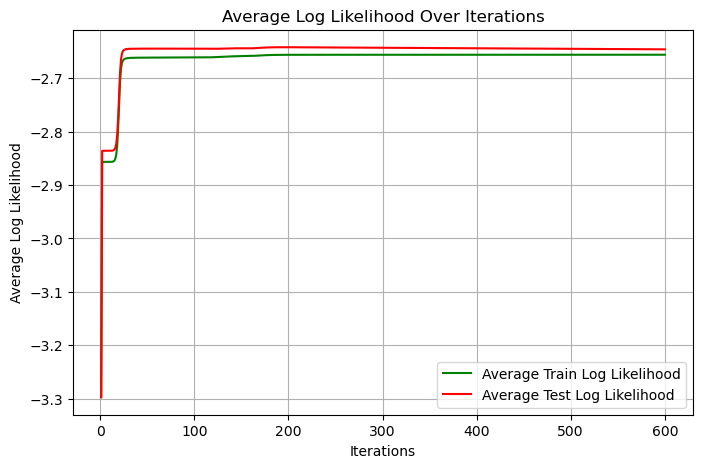

In [30]:
plt.figure(figsize=(8, 5))
iterations = range(1, len(train_log_probs) + 1)
plt.plot(iterations, train_log_probs, linestyle='-', label="Average Train Log Likelihood", color='green')
plt.plot(iterations, test_log_probs, linestyle='-', label="Average Test Log Likelihood", color='red')

plt.xlabel("Iterations")
plt.ylabel("Average Log Likelihood")
plt.title("Average Log Likelihood Over Iterations")
plt.legend()
plt.grid(True)

plt.show()

Plot emission probabilities of a few particular letters

[[[4.13215092e-003 1.16196091e-001]
  [1.73227057e-002 1.27183253e-001]]

 [[7.98592483e-004 3.59731867e-217]
  [3.23548057e-002 6.90023640e-003]]

 [[4.92388377e-015 5.49598901e-004]
  [7.10918216e-002 2.36957883e-002]]

 [[7.42340132e-003 1.86798364e-082]
  [9.62825949e-002 9.68662547e-003]]

 [[3.05389532e-001 1.49887852e-001]
  [1.48266606e-054 5.62681066e-002]]

 [[4.15384128e-003 2.71339389e-254]
  [4.75256889e-002 7.15813744e-003]]

 [[5.59682920e-003 1.05424362e-231]
  [3.69974933e-002 6.12867575e-003]]

 [[2.09919202e-001 1.44854604e-121]
  [2.03818578e-002 1.45643633e-132]]

 [[3.03029335e-003 1.21668449e-001]
  [7.44549948e-004 9.18484506e-002]]

 [[3.18209129e-004 3.76749776e-255]
  [7.49961508e-003 5.83943266e-004]]

 [[5.08842019e-003 1.31722758e-091]
  [1.07281019e-002 3.73077196e-004]]

 [[4.67789441e-002 2.55142197e-196]
  [5.71902645e-002 7.63449553e-002]]

 [[2.08783842e-002 3.46569319e-198]
  [3.65485038e-002 2.16075034e-002]]

 [[5.26088486e-003 7.28899726e-225]
  

Plot emission probability distributions of each state

<Figure size 3200x500 with 0 Axes>

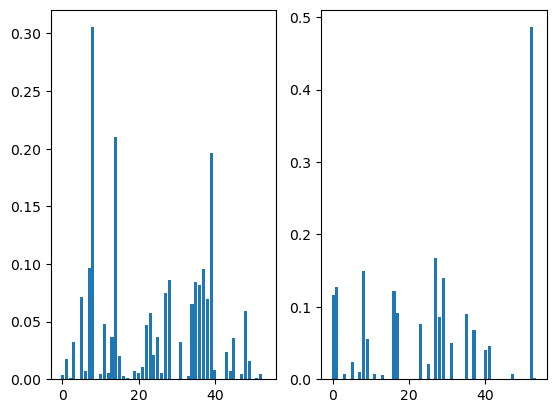

In [28]:
temp = np.transpose(B, (0, 2, 1))

emission1 = np.reshape(temp[:, 0, :], -1)
emission2 = np.reshape(temp[:, 1, :], -1)

plt.figure(figsize=(32, 5))
figure, axis = plt.subplots(1, 2)
axis[0].bar(range(len(emission1)), emission1)
axis[1].bar(range(len(emission2)), emission2)
plt.show()

Analyze Updated Transition Matrix

In [29]:
print(A)

[[0.29394323 0.70605677]
 [0.67650637 0.32349363]]


The updated transition matrix probabilities show that the HMM prefers to transition between states rather than stay in the same state after each time step. This can be seen because the initial transition matrix is near uniform, but the updated transition matrix has signficantly lower values at row 1, col 1 and row 2, col 2. These probabilities represent self loop probabilities. 